In [1]:
# tentar resolver FA0 conforme enunciado
# estequiometria saída do primeira reator está certa?
# revisar parâmetros de entrada do segundo reator
# revisar reatores em série, como resolver
# O ERRO PROVAVELMENTE É A ESTEQUIOMETRIA QUE FIZ PARA LÍQUIDOS. CORRIGIR PARA GASES


# marla fez com limite de temperatura diferente e não mudou os parametros para o segundo reator; mudou a P inicial
#enunciado está estranho para alimentação

# 7. PROJETO DE REATORES DE LEITO FIXO

In [6]:
# importing packages

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sympy as sb

A produção de ácido sulfúrico em escala industrial depende da oxidação do dióxido de enxofre:

$$
SO_2 + \frac{1}{2} O_2 <==> SO_3
$$

Esta reação pode ser catalisada por pentóxido de vanádio (VnO5) suportado em sílica gel, caso em que
a taxa da reação será expressa por:

$$
-r'_{SO_2} =\frac{(k_1 p_{SO_2}p_{O_2} - k_2p_{SO_3}p^{1/2}_{O_2})}{p^{1/2}_{SO_2}}
$$

A reação é altamente exotérmica e reversível, sendo realizada em dois reatores adiabáticos de leito
fixo, em série, intercalados por um trocador de calor, onde é feito o resfriamento da corrente que
alimenta o segundo estágio. Negligenciando todos os efeitos difusivos, determine a quantidade de
catalisador necessária aos dois reatores para que se possa produzir 50 toneladas/dia de ácido
sulfúrico (conversão global de SO2 : 99%), sabendo que a corrente efluente do primeiro estágio deve
estar a temperatura inferior a 560°C para evitar danos ao catalisador. 

Dados
- pressão total na entrada de cada leito:1,3 atm
- temperatura de entrada no primeiro estágio: 370°C
- temperatura do efluente do primeiro estágio: 560°C
- temperatura de entrada no segundo estágio: 370°C
- calor de reação: -24,60 + 1,99 x 10-3 T (kcal/gmol)
- massa específica do catalisador: 600 kg/m3
- diâmetro do reator: 6ft
- assuma catalisador esférico com diâmetro de ¼ in
- viscosidade do gás: 0,09 lb/(h ft)
- porosidade do leito: 0,4

Dados adicionais
- $ ln k_1 = 12.07 - (31000 / RT) $
- $ ln k_12= 22.75 - (53600 / RT) $
- $T$ em $K$, $R$ em $cal / mol . K$
- $k_1$ em $mol / (s g_{cat} atm^{3/2}$
- $k_2$ em $ mol / (s g_{cat} atm) $

|     | %molar | Cp (cal/gmol K)     |
|-----|--------|---------------------|
| N2  | 79     | 6.42 + 1.34e-3 * T  |
| O2  | 13     | 6.74 + 1.64e-3 * T  |
| SO2 | 8      | 9.52 + 3.64e-3 * T  |
| SO3 | 0      | 12.13 + 8.12e-3 * T |

In [1]:
# initial conditions and other constants

P0 = 1.3   #atm
T0 = 643.   #K
x0 = 0.
pA0 = P0 * 0.08  #atm
#FA0 = 5.96e-3   #kmol/s
FA0 = ( 50 / 24 / 3600 * 1000 / 98) / 0.99  # FA0 kmol/s
Mmed = 0.08 * 64 + 0.13 * 32 + 0.79 * 28   #
rog0 = P0 * Mmed / (0.082 * T0)   #kg/m3

EPA = -0.04
tetaB = 1.63
tetaI = 9.88

Eb = 0.4
Ac = 2.6    # m2
rop = 600   # kg/m3

gc = 32.3    # lbm / ft (lbf s2)
visc = 2.5e-5    # lbm / (s ft)
dp=0.0208    # ft
G = 0.1855    # lbm / (ft2 s)

In [4]:
# defining ODEs to run odeint

def odes(vec, L):
    """ Solves coupled ODEs.
    
    Args:
        vec (list of floats): List the initial conditions for variables T, x and P in that order.
        L (numpy array): array to which solve.
        
    Returns:
        list of arrays: returns solved T, x and P for L.
    
    """
    
    # assign each ODE to a vector element
    T = vec[0]
    x = vec[1]
    P = vec[2]   
    
    # coefficients
    k1 = np.exp(12.07) * np.exp(-31000 / (1.987 * T))
    k2 = np.exp(22.75) * np.exp(-53600 / (1.987 * T))
    
    R1 = k1 * (pA0 ** 2) * (1-x) * (tetaB - 0.5 * x) / (1 + EPA * x)**2 * (P**2) / (P0**2)
    R2 = k2 * (pA0** 1.5) * x * (tetaB - 0.5 * x)**0.5 / (1 + EPA * x)**1.5 * (P**1.5) / (P0**1.5)
    R3 = pA0**0.5 * (1-x)**0.5 / (1 + EPA * x)**0.5 * (P**0.5) / (P0**0.5)
    rA = -(R1-R2) / R3    #kmol/(kg s)
    
    somatetacp = 83.87 + 19.537e-3 * T    # kcal / (kmol K)
    deltacp = - 0.76 + 3.66e-3 * T   
    deltaHr = (-24.6 + 1.99e-3 * T) * 1000    #kcal/kmol
    
    betaing = G / (dp * gc) * ((1 - Eb) / Eb ** 3) * (150 * (1 - Eb) * visc / dp + 1.75 * G)    #lbf/ft6
    beta = betaing * 2.82e3 / 1.12    #N/(kg*m6)
    beta0 = (beta/rog0) / 1e5    #atm/m
    
    # define each ODE
    dTdL = -deltaHr * (-rA) / (FA0 * (somatetacp + x * deltacp))*((1 - Eb) * rop * Ac)
    dxdL = -rA/FA0 * ((1 - Eb) * rop * Ac)
    dPdL = -beta0 * (P0/P) * (T/T0) * (1 + EPA * x)
    
    return [dTdL, dxdL, dPdL]

In [7]:
# initial conditions
vec0 = [T0, x0, P0]    # T0 (K), x0, P0 (atm)
L0 = 0.
Lf = 8.    # initial guess
L = np.linspace(L0, Lf, 100)

# solving coupled ODEs
vec_ode = odeint(odes, vec0, L)

T_ode = vec_ode[:, 0]    # assigning solved temperature in L
x_ode = vec_ode[:, 1]    # assigning solved conversion in L
P_ode = vec_ode[:, 2]    # assigning solved pressure in L

Text(0.5, 0.98, 'First Reactor')

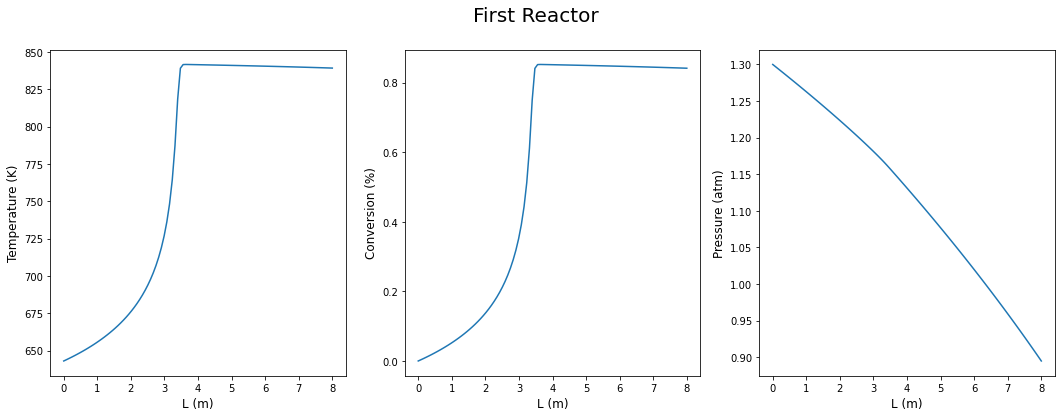

In [8]:
# plot the results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))    # creating subplot

ax[0].plot(L, T_ode)    # plotting T over L
ax[0].set_xlabel("L (m)", fontsize=12)
ax[0].set_ylabel("Temperature (K)", fontsize=12)

ax[1].plot(L, x_ode)    # plotting x over L
ax[1].set_xlabel("L (m)", fontsize=12)
ax[1].set_ylabel("Conversion (%)", fontsize=12)

ax[2].plot(L, P_ode)    # plotting P over L
ax[2].set_xlabel("L (m)", fontsize=12)
ax[2].set_ylabel("Pressure (atm)", fontsize=12)

plt.suptitle('First Reactor', fontsize=20)

In [9]:
# printing some results

Tmax_index = np.where(T_ode == max(T_ode))    # assigns index of maximum temperature in variable Tmax_index

print("-" * 40)
print("Dados para Temperatura Máxima: \n")
print("=" * 40)
print("Tmax = {:.2f} K".format(float(T_ode[Tmax_index])))
print("L(Tmax) = {:.2f} m".format(float(L[Tmax_index])))
print("x(Tmax) = {:.2f} %".format(float(x_ode[Tmax_index] * 100)))
print("P(Tmax) = {:.2f} atm".format(float(P_ode[Tmax_index])))
print("-" * 40)
print("P0 - P(Tmax) = {:.2f} atm".format(float(P_ode[0] - P_ode[Tmax_index])))
print("=" * 40)

print("\n" * 2)

# limiting temperatura to 833 K (the result before it)
Tf = np.where(T_ode == T_ode[T_ode < 833][-1])

# printing results

print("Dados para Temperatura final (inferior a 833 K): \n")
print("=" * 40)
print("Tf = {:.2f} K".format(float(T_ode[Tf])))
print("L(Tf) = {:.2f} m".format(float(L[Tf])))
print("x(Tf) = {:.2f} %".format(float(x_ode[Tf] * 100)))
print("P(Tf) = {:.2f} atm".format(float(P_ode[Tf])))
print("-" * 40)
print("P0 - P(Tf) = {:.2f} atm".format(float(P_ode[0] - P_ode[Tf])))
print("=" * 40)

----------------------------------------
Dados para Temperatura Máxima: 

Tmax = 841.55 K
L(Tmax) = 3.64 m
x(Tmax) = 85.23 %
P(Tmax) = 1.15 atm
----------------------------------------
P0 - P(Tmax) = 0.15 atm



Dados para Temperatura final (inferior a 833 K): 

Tf = 818.38 K
L(Tf) = 3.39 m
x(Tf) = 74.94 %
P(Tf) = 1.16 atm
----------------------------------------
P0 - P(Tf) = 0.14 atm


In [10]:
FA1 = FA0 * (1 - x_ode[Tf]) / (1 + EPA * x_ode[Tf]) * (P_ode[Tf] / P0) * (T0 / T_ode[Tf])
FB1 = (FA0 * tetaB - (1/2) * FA0 * x_ode[Tf]) / (1 + EPA * x_ode[Tf]) * (P_ode[Tf] / P0) * (T0 / T_ode[Tf])
FI1 = (FA0 * tetaI) / (1 + EPA * x_ode[Tf]) * (P_ode[Tf] / P0) * (T0 / T_ode[Tf])
FP1 = (0. + FA0 * x_ode[Tf]) / (1 + EPA * x_ode[Tf]) * (P_ode[Tf] / P0) * (T0 / T_ode[Tf])
FT1 = FA1 + FB1 + FP1 + FI1

print("First Reactor Effluents:\n")
print("Second reactor's feeding:")

print("FA1 = {:.6f} kmol/s".format(float(FA1)))
print("FB1 = {:.6f} kmol/s".format(float(FB1)))
print("FI1 = {:.6f} kmol/s".format(float(FI1)))
print("FP1 = {:.6f} kmol/s".format(float(FP1)))
print("-" * 30)
print("FT1 = {:.6f} kmol/s".format(float(FT1)))

print("=" * 30)
print("\n")

yA1 = FA1 / FT1
yB1 = FB1 / FT1
yP1 = FP1 / FT1
yI1 = FI1 / FT1

print("yA1 = {:.2f}".format(float(yA1)))
print("yB1 = {:.2f}".format(float(yB1)))
print("yP1 = {:.2f}".format(float(yP1)))
print("yI1 = {:.2f}".format(float(yI1)))

tetaB1 = yB1 / yA1
tetaI1 = yI1 / yA1
tetaP1 = yP1 / yA1

print("\n")

print("tetaB1 = {:.2f}".format(float(tetaB1)))
print("tetaP1 = {:.2f}".format(float(tetaP1)))
print("tetaI1 = {:.2f}".format(float(tetaI1)))

First Reactor Effluents:

Second reactor's feeding:
FA1 = 0.001083 kmol/s
FB1 = 0.005424 kmol/s
FI1 = 0.042693 kmol/s
FP1 = 0.003238 kmol/s
------------------------------
FT1 = 0.052439 kmol/s


yA1 = 0.02
yB1 = 0.10
yP1 = 0.06
yI1 = 0.81


tetaB1 = 5.01
tetaP1 = 2.99
tetaI1 = 39.42


## Second Reactor

Entrada do primeiro reator:

$ F_{A0} = 5.965 . 10^{-3} kmol/s $

$ F_{B0} = 9.715 . 10^{-3} kmol/s $ ; 
$ \theta_{B} = 1.63 $

$ F_{I0} =  58.885 . 10^{-3} kmol/s $ ;
$ \theta_{I} = 9.88 $

Entrada do segundo reator:

$ F_{A1} =  1.463 . 10^{-3} kmol/s $

$ F_{B1} =  7.466 . 10^{-3} kmol/s $ ;
$ \theta_{B1} = 5.10 $

$ F_{I1} =  58.885 . 10^{-3} kmol/s $ ;
$ \theta_{I1} = 40.26 $

$ F_{P1} =  4.497 . 10^{-3} kmol/s $ ;
$ \theta_{P1} = 3.07 $

In [11]:
# I DID
# initial conditions and other constants

P1 = 1.3   #atm
T1 = 643.   #K
pA1 = P1 * yA1  #atm CHANGED
#FA0 = 5.96e-3   #kmol/s
Mmed1 = yA1 * 64 + yB1 * 32 + yI1 * 28 + yP1 * 80   # CHANGED
rog1 = P1 * Mmed1 / (0.082 * T1)   #kg/m3

EPA1 = - 0.5 * yA1
#tetaB = 1.63
#tetaI = 9.88

Eb = 0.4
Ac = 2.6    # m2
rop = 600   # kg/m3

gc = 32.3    # lbm / ft (lbf s2)
visc = 2.5e-5    # lbm / (s ft)
dp=0.0208    # ft
G = 0.1855    # lbm / (ft2 s)

In [12]:
# defining ODEs to run odeint

def odes1(vec, L):
    """ Solves coupled ODEs.
    
    Args:
        vec (list of floats): List the initial conditions for variables T, x and P in that order.
        L (numpy array): array to which solve.
        
    Returns:
        list of arrays: returns solved T, x and P for L.
    
    """
    
    # assign each ODE to its initial condition
    T = vec[0]
    x = vec[1]
    P = vec[2]   
    
    # coefficients
    k1 = np.exp(12.07) * np.exp(-31000 / (1.987 * T))
    k2 = np.exp(22.75) * np.exp(-53600 / (1.987 * T))
    
    R1 = k1 * (pA1 ** 2) * (1-x) * (tetaB1 - 0.5 * x) / (1 + EPA1 * x)**2 * (P**2) / (P1**2)
    R2 = k2 * (pA1** 1.5) * x * (tetaB1 - 0.5 * x)**0.5 / (1 + EPA1 * x)**1.5 * (P**1.5) / (P1**1.5)
    R3 = pA1**0.5 * (1-x)**0.5 / (1 + EPA1 * x)**0.5 * (P**0.5) / (P1**0.5)
    rA = -(R1-R2) / R3    #kmol/(kg s)
    
    somatetacp1 = 339.686 + 0.1169215 * T    # kcal / (kmol K)
    deltacp = - 0.76 + 3.66e-3 * T   
    deltaHr = (-24.6 + 1.99e-3 * T) * 1000    #kcal/kmol
    
    betaing = G / (dp * gc) * ((1 - Eb) / Eb ** 3) * (150 * (1 - Eb) * visc / dp + 1.75 * G)    #lbf/ft6
    beta = betaing * 2.82e3 / 1.12    #N/(kg*m6)
    beta1 = (beta/rog1) / 1e5    #atm/m
    
    # define each ODE
    dTdL = -deltaHr * (-rA) / (FA1 * (somatetacp1 + x * deltacp))*((1 - Eb) * rop * Ac)
    dxdL = -rA/FA1 * ((1 - Eb) * rop * Ac)
    dPdL = -beta1 * (P1/P) * (T/T1) * (1 + EPA1 * x)
    
    return np.array([dTdL[0], dxdL[0], dPdL[0]])

In [50]:
# initial conditions
vec1 = np.array([T0, float(x_ode[Tf]), P0])  # T0 (K), x0, P0 (atm)
L0 = 0.
Lf = 20.    # initial guess
L1 = np.linspace(L0, Lf, 100)

# solving coupled ODEs
vec_ode1 = odeint(odes1, vec1, L1)

T_ode1 = vec_ode1[:, 0]    # assigning solved temperature in L
x_ode1 = vec_ode1[:, 1]    # assigning solved conversion in L
P_ode1 = vec_ode1[:, 2]    # assigning solved pressure in L

x_99 = np.where(x_ode1 == x_ode1[x_ode1 > 0.99][0])
x_ode1

C:\Users\LUCCAM~1\AppData\Local\Temp/ipykernel_8168/2366186587.py:25: RuntimeWarning: invalid value encountered in double_scalars
  R2 = k2 * (pA1** 1.5) * x * (tetaB1 - 0.5 * x)**0.5 / (1 + EPA1 * x)**1.5 * (P**1.5) / (P1**1.5)
C:\Users\LUCCAM~1\AppData\Local\Temp/ipykernel_8168/2366186587.py:26: RuntimeWarning: invalid value encountered in double_scalars
  R3 = pA1**0.5 * (1-x)**0.5 / (1 + EPA1 * x)**0.5 * (P**0.5) / (P1**0.5)


array([0.74938913, 0.75840854, 0.76734475, 0.7761907 , 0.7849393 ,
       0.79358336, 0.80211564, 0.81052885, 0.81881566, 0.8269688 ,
       0.83498102, 0.84284512, 0.85055404, 0.85810082, 0.86547869,
       0.87268103, 0.87970151, 0.88653404, 0.89317284, 0.89961242,
       0.90584769, 0.91187394, 0.91768688, 0.92328266, 0.92865793,
       0.93380979, 0.93873591, 0.94343445, 0.94790416, 0.95214434,
       0.95615487, 0.95993621, 0.96348943, 0.96681621, 0.96991885,
       0.97280026, 0.97546402, 0.97791436, 0.98015619, 0.98219512,
       0.98403757, 0.98569069, 0.98716249, 0.98846189, 0.98959869,
       0.99058358, 0.99142813, 0.99214456, 0.99274559, 0.99324417,
       0.99365313, 0.99398483, 0.99425086, 0.99446181, 0.99462697,
       0.99475446, 0.99485123, 0.994923  , 0.99497449, 0.99500955,
       0.99503128, 0.99504213, 0.99504406, 0.99503864, 0.99502708,
       0.99501034, 0.99498916, 0.99496413, 0.99493568, 0.99490416,
       0.99486982, 0.99483284, 0.99479337, 0.99475148, 0.99470

Text(0.5, 0.98, 'Second Reactor')

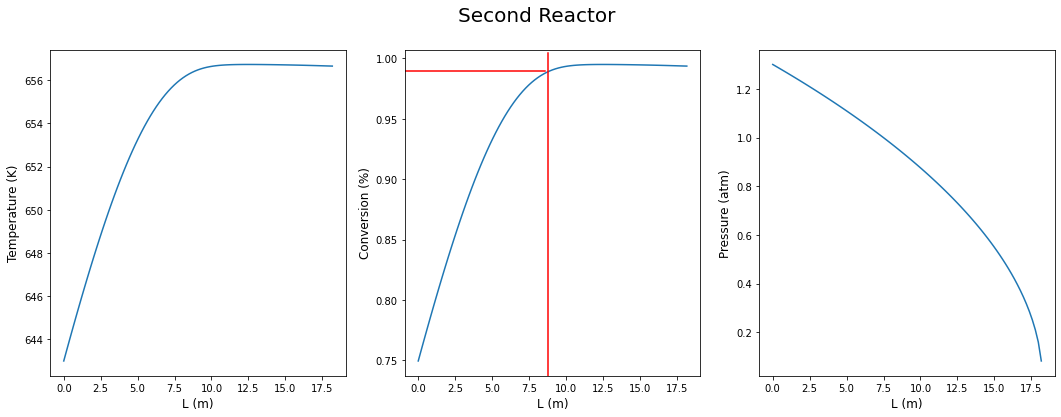

In [58]:
# plot the results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))    # creating subplot

ax[0].plot(L1, T_ode1)    # plotting T over L
ax[0].set_xlabel("L (m)", fontsize=12)
ax[0].set_ylabel("Temperature (K)", fontsize=12)

ax[1].plot(L1, x_ode1)    # plotting x over L
ax[1].set_xlabel("L (m)", fontsize=12)
ax[1].set_ylabel("Conversion (%)", fontsize=12)

ax[2].plot(L1, P_ode1)    # plotting P over L
ax[2].set_xlabel("L (m)", fontsize=12)
ax[2].set_ylabel("Pressure (atm)", fontsize=12)

# PLOT variables at 99% conversion
ax[1].axhline(y=0.99, xmin=0, xmax=9.50/20, color='r', linestyle='-')
ax[1].axvline(x=8.8, ymin=0/1, ymax=.99/1.0, color ='r', linestyle='-')

plt.suptitle('Second Reactor', fontsize=20)

In [49]:
x_99_index = np.where(x_ode1 == x_ode1[x_ode1 > 0.99][0])
x_99 = x_ode1[x_99_index]

# printing some results

print("-" * 40)
print("Dados para Conversão de 99% : \n")
print("=" * 40)
print("L (x = 0.99) = {:.2f} m.".format(L1[x_99_index][0]))
print("T (x = 0.99) = {:.2f} K.".format(T_ode1[x_99_index][0]))
print("P (x = 0.99) = {:.2f} atm.".format(P_ode1[x_99_index][0]))
print("-" * 40)
print("P0 - P(Tmax) = {:.2f} atm".format(float(P_ode1[0] - P_ode1[x_99_index])))
print("=" * 40)

print("\n" * 2)

----------------------------------------
Dados para Conversão de 99% : 

L (x = 0.99) = 9.09 m.
T (x = 0.99) = 656.48 K.
P (x = 0.99) = 0.92 atm.
----------------------------------------
P0 - P(Tmax) = 0.38 atm





In [67]:
FA2 = FA0 * (1 - x_ode1[x_99_index]) / (1 + EPA * x_ode1[x_99_index]) * (P_ode1[x_99_index] / P0) * (T0 / T_ode1[x_99_index])
FB2 = FB1 + (FA1 * tetaB1 - (1/2) * FA1 * x_ode1[x_99_index]) / (1 + EPA * x_ode1[x_99_index]) * (P_ode1[x_99_index] / P0) * (T0 / T_ode1[x_99_index])
FI2 = FA0 * tetaI1  / (1 + EPA * x_ode1[x_99_index]) * (P_ode1[x_99_index] / P0) * (T0 / T_ode1[x_99_index])
FP2 = (FP1 + FA0 * x_ode1[x_99_index])  / (1 + EPA * x_ode1[x_99_index]) * (P_ode1[x_99_index] / P0) * (T0 / T_ode1[x_99_index])
FT2 = FA2 + FB2 + FP2 + FI2

print("First Reactor Effluents:\n")
print("Second reactor's feeding:")

print("FA1 = {:.6f} kmol/s".format(float(FA1)))
print("FB1 = {:.6f} kmol/s".format(float(FB1)))
print("FI1 = {:.6f} kmol/s".format(float(FI1)))
print("FP1 = {:.6f} kmol/s".format(float(FP1)))
print("-" * 30)
print("FT1 = {:.6f} kmol/s".format(float(FT1)))

print("=" * 30)
print("\n")

print("Second reactor's effluents:\n")

print("FA2= {:.6f} kmol/s".format(float(FA2)))
print("FB2= {:.6f} kmol/s".format(float(FB2)))
print("FI2= {:.6f} kmol/s".format(float(FI2)))
print("FP2= {:.6f} kmol/s".format(float(FP2)))
print("-" * 30)
print("FT2= {:.6f} kmol/s".format(float(FT2)))

print("=" * 30)
print("\n")

yA2 = FA2 / FT2
yB2 = FB2 / FT2
yP2 = FP2 / FT2
yI2 = FI2 / FT2

print("yA2 = {:.2f}".format(float(yA2)))
print("yB2 = {:.2f}".format(float(yB2)))
print("yP2 = {:.2f}".format(float(yP2)))
print("yI2 = {:.2f}".format(float(yI2)))

tetaB2 = yB2 / yA2
tetaI2 = yI2 / yA2
tetaP2 = yP2 / yA2

print("\n")

print("tetaB2 = {:.2f}".format(float(tetaB2)))
print("tetaP2 = {:.2f}".format(float(tetaP2)))
print("tetaI2 = {:.2f}".format(float(tetaI2)))

First Reactor Effluents:

Second reactor's feeding:
FA1 = 0.001083 kmol/s
FB1 = 0.005424 kmol/s
FI1 = 0.042693 kmol/s
FP1 = 0.003238 kmol/s
------------------------------
FT1 = 0.052439 kmol/s


Second reactor's effluents:

FA2= 0.000041 kmol/s
FB2= 0.008963 kmol/s
FI2= 0.170216 kmol/s
FP2= 0.006621 kmol/s
------------------------------
FT2= 0.185841 kmol/s


yA2 = 0.00
yB2 = 0.05
yP2 = 0.04
yI2 = 0.92


tetaB2 = 220.45
tetaP2 = 162.85
tetaI2 = 4186.69


# Quanto de catalisador é necessário?

$$ W = \rho_{b} A_c L$$
$$ W = \rho_{P} . (1 - \epsilon_{b}) . A_c . (L_1 + L_2)$$

In [64]:
rho_p = 600    # kg / m3

W = rho_p * (1 - Eb) * Ac * (L[Tmax_index] + L1[x_99_index])[0]


print("A massa necessária de catalisador é aproximadamente {:.2f} kg".format(float(W)))
print("Isso equivale a {:.2f} toneladas".format(float(W / 1000.)))

A massa necessária de catalisador é aproximadamente 11912.73 kg
Isso equivale a 11.91 toneladas
